In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
import os
import os.path
import pytest
import os.path as op
import sys
import matplotlib.pyplot as plt
import scipy
import glob
from pathlib import Path

sys.path.insert(0,str(Path("~/projects/imtools").expanduser()))

import imtools.trainer3d
import imtools.ml
import imtools.datasets
import sklearn
import sklearn.metrics
import sklearn.neural_network
import io3d
import sed3
import joblib
from loguru import logger
# logger.disable("io3d")
logger.remove()
logger.add(sys.stderr, level='INFO')

3

# Training
## Define feature function
Input is 3D array and voxelsize. Output is feature vector with rows number equal to pixel number and cols number equal
to number of features.

In [6]:
def externfv(data3d, voxelsize_mm):        # scale
    f0 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=3).reshape(-1, 1)
    f1 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=1).reshape(-1, 1) - f0
    fv = np.concatenate([
        f0, f1
    ], 1)
    return fv

## Classifier selection

Any classifier with `fit()` and `predict()` function can be used.

Decision tree:
```python
import sklearn.tree
cl = sklearn.tree.DecisionTreeClassifier()

```
Neural Network Classifier:
```python
import sklearn.neural_network
cl = sklearn.neural_network.MLPClassifier()
```

GMM 1 component for foreground, 3 components for background:
```python
cl = imtools.ml.gmmcl.GMMCl()
cl.cl = {0:sklearn.mixture.GaussianMixture(n_components=3), 1:sklearn.mixture.GaussianMixture(n_components=1)}
```

In [8]:
# select classifier
cl = imtools.ml.gmmcl.GMMCl(n_components=3) # both foreground and background gmm with 3 components

# init trainer
ol = imtools.trainer3d.Trainer3D(classifier=cl)
# select feature function
ol.feature_function = externfv

for i in range(1, 5):
    datap = io3d.datasets.read_dataset("3Dircadb1", 'data3d', i)
    datap_liver = io3d.datasets.read_dataset("3Dircadb1", 'liver', i)
    ol.add_train_data(datap["data3d"], (datap_liver["data3d"] > 0).astype(np.uint8), voxelsize_mm=datap["voxelsize_mm"])

ol.fit()
# save to file
joblib.dump(ol, "ol.joblib")

['ol.joblib']

# Testing

In [9]:
# load trained from file
ol = joblib.load("ol.joblib")

# one = list(imtools.datasets.sliver_reader("*000.mhd", read_seg=True))[0]
# numeric_label, vs_mm, oname, orig_data, rname, ref_data = one
i = 3
datap = io3d.datasets.read_dataset("3Dircadb1", 'data3d', i)
fit = ol.predict(datap["data3d"], voxelsize_mm=datap["voxelsize_mm"])



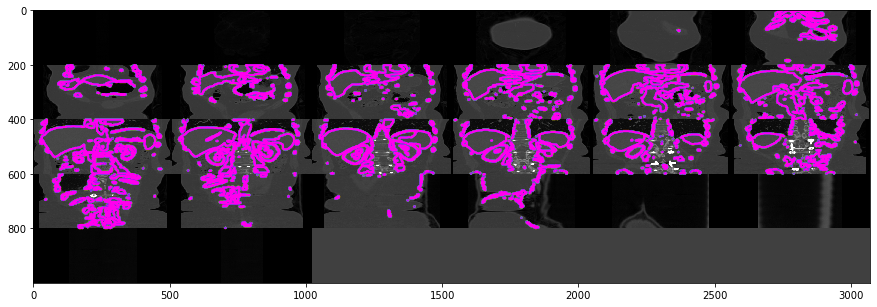

In [10]:
#  visualization
plt.figure(figsize=(15, 10))
sed3.show_slices(datap["data3d"], fit, slice_step=20, axis=1, flipV=False)


# Evaluation

In [14]:

datap_liver = io3d.datasets.read_dataset("3Dircadb1", 'liver', i)
ground_true = (datap_liver['data3d'] > 0).astype(np.uint8)
print(sklearn.metrics.classification_report(ground_true.ravel(), fit.astype(np.uint8).ravel()))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97  50053721
           1       0.42      0.95      0.59   2375079

    accuracy                           0.94  52428800
   macro avg       0.71      0.94      0.78  52428800
weighted avg       0.97      0.94      0.95  52428800

